# Stochastic Variational Gaussian Process Regression

**Zhenwen Dai (2019-05-29)**

## Introduction

Gaussian process (GP) is computationally expensive. A popular approach to scale up GP regression on large data is to use stochastic variational inference with mini-batch training (Hensman et al., 2013). SVGP regression with Gaussian noise has been implemented as a module in MXFusion.

In [32]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

## Toy data

We generate some synthetic data for our regression example. The data set is generate from a sine function with some additive Gaussian noise. 

In [2]:
import numpy as np
%matplotlib inline
from pylab import *

np.random.seed(0)
X = np.random.uniform(-3.,3.,(1000,1))
Y = np.sin(X) + np.random.randn(1000,1)*0.05

The generated data are visualized as follows:

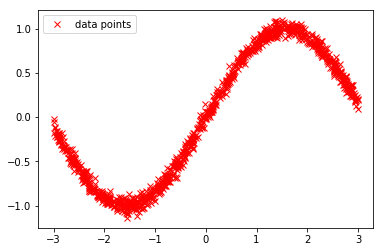

In [3]:
plot(X, Y, 'rx', label='data points')
_=legend()

In [4]:
from mxfusion.common import config
config.DEFAULT_DTYPE = 'float64'

The SVGP regression model is created as follow. Two SVGP specific parameters are ```num_inducing``` which specifies the number of inducing points used in the variational sparse GP approximation and ```svgp_log_pdf.jitter``` which the jitter term in the log pdf calculation for numerical robustness. 

In [33]:
from mxfusion import Model, Variable
from mxfusion.components.variables import PositiveTransformation
from mxfusion.components.distributions.gp.kernels import RBF
from mxfusion.modules.gp_modules import SVGPRegression

m = Model()
m.N = Variable()
m.X = Variable(shape=(m.N, 1))
m.noise_var = Variable(shape=(1,), transformation=PositiveTransformation(), initial_value=0.01)
m.kernel = RBF(input_dim=1, variance=1, lengthscale=1)
m.Y = SVGPRegression.define_variable(X=m.X, kernel=m.kernel, noise_var=m.noise_var, shape=(m.N, 1), num_inducing=20)
m.Y.factor.svgp_log_pdf.jitter = 1e-6

Inference is done by creating the inference instance from the ```GradBasedInference``` class, in which we use a ```MAP``` inference algorithm as there are no latent variables outside the SVGPRegression module. Additional, we specify ```grad_loop``` to be ```MiniBatchInferenceLoop``` in which we set the size of mini-batch and the scaling factor for minibatch training.

Then, training is triggered by calling the ```run``` method.

In [38]:
import mxnet as mx
from mxfusion.inference import GradBasedInference, MAP, MinibatchInferenceLoop

infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.X, m.Y]), 
                          grad_loop=MinibatchInferenceLoop(batch_size=10, rv_scaling={m.Y: 1000/10}))
infr.initialize(X=(1000,1), Y=(1000,1))
infr.params[m.Y.factor.inducing_inputs] = mx.nd.array(np.random.randn(20, 1), dtype='float64')
infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'), 
         max_iter=50, learning_rate=0.1, verbose=True)
infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'), 
         max_iter=50, learning_rate=0.01, verbose=True)

epoch 1 Iteration 100 loss: 933115.0603707978			epoch-loss: 10413624.614005275 
epoch 2 Iteration 100 loss: 524948.7079326594			epoch-loss: 686034.5295730559 
epoch 3 Iteration 100 loss: 345602.4022749258			epoch-loss: 427065.8343717841 
epoch 4 Iteration 100 loss: 277011.3760208657			epoch-loss: 297071.493696023 
epoch 5 Iteration 100 loss: 183347.13021907964			epoch-loss: 219808.0871498559 
epoch 6 Iteration 100 loss: 143763.11007552472			epoch-loss: 169486.20729875282 
epoch 7 Iteration 100 loss: 132031.47695326462			epoch-loss: 134765.1471133905 
epoch 8 Iteration 100 loss: 95632.60561449913			epoch-loss: 109798.66321648406 
epoch 9 Iteration 100 loss: 73957.6220462552			epoch-loss: 91257.8705670977 
epoch 10 Iteration 100 loss: 64840.07207031624			epoch-loss: 77084.06942481917 
epoch 11 Iteration 100 loss: 60780.27278575914			epoch-loss: 65962.38163622493 
epoch 12 Iteration 100 loss: 48546.66342698521			epoch-loss: 57037.39009905885 
epoch 13 Iteration 100 loss: 42676.90726357933

The learned kernel parameters are as follows:

In [44]:
print('The estimated variance of the RBF kernel is %f.' % infr.params[m.kernel.variance].asscalar())
print('The estimated length scale of the RBF kernel is %f.' % infr.params[m.kernel.lengthscale].asscalar())
print('The estimated variance of the Gaussian likelihood is %f.' % infr.params[m.noise_var].asscalar())

The estimated variance of the RBF kernel is 0.220715.
The estimated length scale of the RBF kernel is 0.498507.
The estimated variance of the Gaussian likelihood is 0.003107.


## Prediction

The prediction of a SVGP model can be done by creating a ```TransferInference``` instance.

In [45]:
from mxfusion.inference import TransferInference, ModulePredictionAlgorithm
infr_pred = TransferInference(ModulePredictionAlgorithm(model=m, observed=[m.X], target_variables=[m.Y]), 
                              infr_params=infr.params)
m.Y.factor.svgp_predict.jitter = 1e-6

To visualize the fitted model, we make predictions on 100 points evenly spanned from -5 to 5. We estimate the mean and variance of the noise-free output $F$.

In [46]:
xt = np.linspace(-5,5,100)[:, None]
res = infr_pred.run(X=mx.nd.array(xt, dtype='float64'))[0]
f_mean, f_var = res[0].asnumpy()[0], res[1].asnumpy()[0]

The resulting figure is shown as follows:

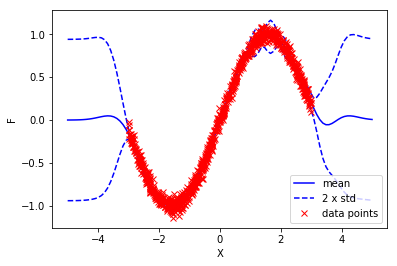

In [47]:
plot(xt, f_mean[:,0], 'b-', label='mean')
plot(xt, f_mean[:,0]-2*np.sqrt(f_var[:, 0]), 'b--', label='2 x std')
plot(xt, f_mean[:,0]+2*np.sqrt(f_var[:, 0]), 'b--')
plot(X, Y, 'rx', label='data points')
ylabel('F')
xlabel('X')
_=legend()